In [6]:
import vrep 
import sys
import time 
import numpy as np
from tank import *
from IPython.display import clear_output
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import warnings
warnings.simplefilter("ignore", UserWarning)

# Parkowanie równoległe

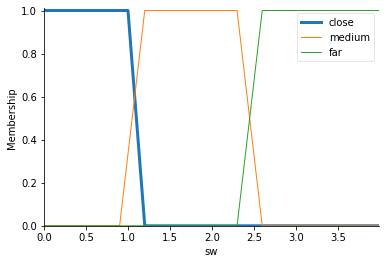

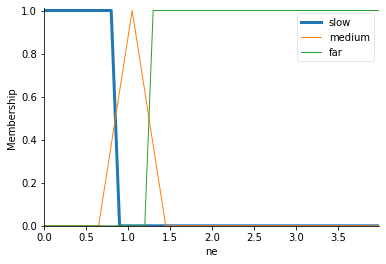

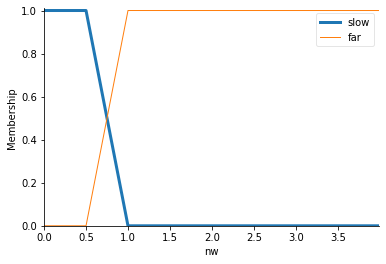

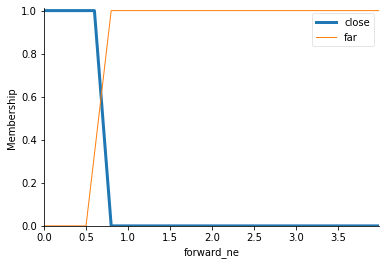

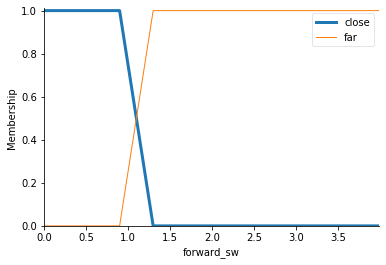

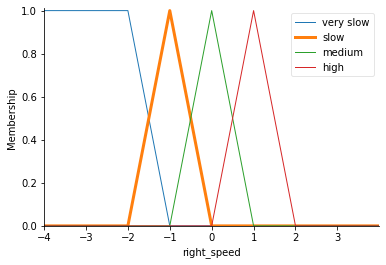

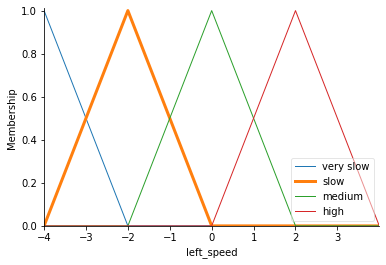

In [7]:
sw = ctrl.Antecedent(np.arange(0, 4, 0.01), 'sw')
sw['close'] = fuzz.trapmf(sw.universe, [0, 0, 1, 1.2])
sw['medium'] = fuzz.trapmf(sw.universe, [0.9, 1.2, 2.3, 2.6])
sw['far'] = fuzz.trapmf(sw.universe, [2.3, 2.6, 4, 4])
sw['close'].view()

ne = ctrl.Antecedent(np.arange(0, 4, 0.01), 'ne')
ne['slow'] = fuzz.trapmf(ne.universe, [0, 0, 0.8, 0.9])
ne['medium'] = fuzz.trimf(ne.universe, [0.65, 1.05, 1.45])
ne['far'] = fuzz.trapmf(ne.universe, [1.2, 1.3, 4, 4])
ne['slow'].view()

nw = ctrl.Antecedent(np.arange(0, 4, 0.01), 'nw')
nw['slow'] = fuzz.trapmf(nw.universe, [0, 0, 0.5, 1])
nw['far'] = fuzz.trapmf(nw.universe, [0.5, 1, 4, 4])
nw['slow'].view()


forward_ne = ctrl.Antecedent(np.arange(0, 4, 0.01), 'forward_ne')
forward_ne['close'] = fuzz.trapmf(forward_ne.universe, [0, 0, 0.6, 0.8])
forward_ne['far'] = fuzz.trapmf(forward_ne.universe, [0.5, 0.8, 4, 4])
forward_ne['close'].view()

forward_sw = ctrl.Antecedent(np.arange(0, 4, 0.01), 'forward_sw')
forward_sw['close'] = fuzz.trapmf(forward_sw.universe, [0, 0, 0.9, 1.3])
forward_sw['far'] = fuzz.trapmf(forward_sw.universe, [0.9, 1.3, 4, 4])
forward_sw['close'].view()

right_speed = ctrl.Consequent(np.arange(-4, 4, 0.01), 'right_speed')
right_speed['very slow'] = fuzz.trapmf(right_speed.universe, [-4, -4, -2, -1])
right_speed['slow'] = fuzz.trimf(right_speed.universe, [-2, -1, -0])
right_speed['medium'] = fuzz.trimf(right_speed.universe, [-1, 0, 1])
right_speed['high'] = fuzz.trimf(right_speed.universe, [0, 1, 2])
right_speed['slow'].view()

left_speed = ctrl.Consequent(np.arange(-4, 4, 0.01), 'left_speed')
left_speed['very slow'] = fuzz.trapmf(left_speed.universe, [-4, -4, -4, -2])
left_speed['slow'] = fuzz.trimf(left_speed.universe, [-4, -2, 0])
left_speed['medium'] = fuzz.trimf(left_speed.universe, [-2, 0, 2])
left_speed['high'] = fuzz.trimf(left_speed.universe, [0, 2, 4])
left_speed['slow'].view()

In [8]:
back_rule1 = ctrl.Rule(sw['medium'], right_speed['very slow'])
back_rule2 = ctrl.Rule(sw['close'], right_speed['medium'])
back_rule3 = ctrl.Rule(sw['far'], left_speed['very slow'])
back_rule4 = ctrl.Rule(ne['medium'], left_speed['medium'])
back_rule5 = ctrl.Rule(ne['slow'], left_speed['slow'])
back_rule6 = ctrl.Rule(sw['far'], right_speed['medium'])
back_rule7 = ctrl.Rule(sw['medium'], left_speed['very slow'])
back_rule8 = ctrl.Rule(sw['close'], left_speed['medium'])

backward_ctrl = ctrl.ControlSystem([back_rule1, back_rule2, back_rule3, back_rule4, back_rule5, back_rule6, back_rule7, back_rule8])
backward = ctrl.ControlSystemSimulation(backward_ctrl)

forward_rule1 = ctrl.Rule(forward_sw['close'] & forward_ne['far'], right_speed['high'])
forward_rule2 = ctrl.Rule(forward_sw['close'] & forward_ne['far'], left_speed['high'])
forward_rule3 = ctrl.Rule(forward_ne['close'] & forward_sw['far'], right_speed['medium'])
forward_rule4 = ctrl.Rule(forward_ne['close'] & forward_sw['far'], left_speed['medium'])
forward_rule5 = ctrl.Rule(forward_sw['far'], right_speed['medium'])
forward_rule6 = ctrl.Rule(forward_sw['far'], left_speed['medium'])

forward_ctrl = ctrl.ControlSystem([forward_rule1, forward_rule2, forward_rule3, forward_rule4, forward_rule5, forward_rule6])
forward = ctrl.ControlSystemSimulation(forward_ctrl)

In [9]:
vrep.simxFinish(-1)  # closes all opened connections, in case any prevoius wasnt finished
clientID = vrep.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # start a connection

if clientID != -1:
    print("Connected to remote API server")
else:
    print("Not connected to remote API server")
    sys.exit("Could not connect")

Connected to remote API server


In [10]:
tank = Tank(clientID)
proximity_sensors = ["EN", "ES", "NE", "NW", "SE", "SW", "WN", "WS"]
proximity_sensors_handles = [0] * 8

    # get handle to proximity sensors
for i in range(len(proximity_sensors)):
    err_code, proximity_sensors_handles[i] = vrep.simxGetObjectHandle(clientID,
                                                                          "Proximity_sensor_" + proximity_sensors[i],
                                                                          vrep.simx_opmode_blocking)

    # first reading should be done with simx_opmode_streaming, further with simx_opmode_buffer parameter
for sensor_name, sensor_handle in zip(proximity_sensors, proximity_sensors_handles):
    err_code, detectionState, detectedPoint, detectedObjectHandle, detectedSurfaceNormalVector = vrep.simxReadProximitySensor(
        clientID, sensor_handle, vrep.simx_opmode_streaming)

tank.forward(7)
time.sleep(10)
t = time.time()
stop = False  # used to stop the tank at the beginning
is_straightening = False  # After parking
is_place_found = False

tank.rightvelocity = 3  
tank.leftvelocity = 3  
tank.setVelocity()

while (time.time() - t) < 200:
    ne_dist = np.linalg.norm(vrep.simxReadProximitySensor(clientID, 83, vrep.simx_opmode_buffer)[2])
    se_dist = np.linalg.norm(vrep.simxReadProximitySensor(clientID, 78, vrep.simx_opmode_buffer)[2])
    sw_dist = np.linalg.norm(vrep.simxReadProximitySensor(clientID, 79, vrep.simx_opmode_buffer)[2])

    if not is_place_found:
        if se_dist >= 2.8 and ne_dist < 1.31:
            is_place_found = True

    if is_place_found:
        forward.input['forward_sw'] = sw_dist
        forward.input['forward_ne'] = ne_dist
        forward.compute()

        backward.input['sw'] = sw_dist
        backward.input['ne'] = ne_dist
        backward.compute()

        if is_straightening:
            right_speed = forward.output['right_speed']
            left_speed = forward.output['left_speed']

        else:
            right_speed = backward.output['right_speed']
            left_speed = backward.output['left_speed']

        tank.rightvelocity = right_speed
        tank.leftvelocity = left_speed
        tank.setVelocity()

        if sw_dist < 0.91 and forward.output['left_speed'] > 0.1 and not is_straightening:
            print('Straightening')
            is_straightening = True

    time.sleep(0.2)

Straightening


ValueError: Crisp output cannot be calculated, likely because the system is too sparse. Check to make sure this set of input values will activate at least one connected Term in each Antecedent via the current set of Rules.

# Parkowanie prostopadłe

In [20]:
def stopPerpendicular(sensors,tank):
    if sensors["NE"] > 2 and sensors["NE"] < 3:
        tank.stop()
    #if(sensors["WN"] > 2.0 and sensors["WN"] < 2.1 and sensors["WS"] < 2.1 and sensors["WS"] > 2.0 and sensors["SW"] > 1.2 and sensors['SW'] < 1.80):
    #    tank.stop()

In [21]:
 
def parkPerpendicular(sensors,tank,model,modelStop):
    global turn
    global forward
    summ = 0
    average = getSum(sensors) / 8
    if average > 2:
        average = 2
    print("average:",average)
    if sensors["NE"] > 2.1 and sensors["NE"] < 2.8 and not turn and not forward:
        turn = True
        print("Zatrzymanie czołgu")
    if sensors['NE'] < 1.15 and sensors["NW"] < 1.16 and not forward and turn:
        forward = True
    if turn and not forward:
        model.input['dist'] = sensors["NW"]
        model.compute()
        right_speed = model.output['right_vel']
        left_speed = model.output['left_vel']
        tank.rightvelocity = right_speed
        tank.leftvelocity = left_speed
        tank.setVelocity()
    if forward:
        modelStop.input['dist'] = average
        modelStop.compute()
        speed = modelStop.output['speed']
        print("speed:",speed)
        tank.forward(speed)
        
def getSum(sensors):
    summ = 0
    for sensor in sensors:
        summ += sensors[sensor]
    return summ

In [22]:
def getPerpendicular():
    right_speed = ctrl.Consequent(np.arange(0, 10, 0.01), 'right_vel')
    right_speed['minimal'] = fuzz.trimf(right_speed.universe, [0, 0, 0.1])
    right_speed['low'] = fuzz.trimf(right_speed.universe, [0, 0.1, 3])
    right_speed['medium'] = fuzz.trimf(right_speed.universe, [0.1, 3, 8])
    right_speed['high'] = fuzz.trapmf(right_speed.universe, [3,8, 10, 10])
    #right_speed['minimal'].view()

    left_speed = ctrl.Consequent(np.arange(0, 10, 0.01), 'left_vel')
    left_speed['minimal'] = fuzz.trimf(left_speed.universe, [0, 0, 0.1])
    left_speed['low'] = fuzz.trimf(left_speed.universe, [0.1, 1, 2.2])
    left_speed['medium'] = fuzz.trimf(left_speed.universe, [1, 2.2, 5.2])
    left_speed['high'] = fuzz.trapmf(left_speed.universe, [2.2, 5.2,10, 10])
    #left_speed['high'].view()

    north_west_dist = ctrl.Antecedent(np.arange(0, 4, 0.01), 'dist')
    north_west_dist['very close'] = fuzz.trapmf(north_west_dist.universe, [0, 0, 0.5, 0.6])
    north_west_dist['close'] = fuzz.trapmf(north_west_dist.universe, [0.5, 0.6, 0.9, 1])
    north_west_dist['medium'] = fuzz.trapmf(north_west_dist.universe, [0.9, 1, 2.6, 2.8])
    north_west_dist['far'] = fuzz.trapmf(north_west_dist.universe, [2.6, 2.8, 4, 4])
    #north_west_dist['far'].view()
    
    
    
    rule1 = ctrl.Rule(north_west_dist['very close'], left_speed['minimal'])
    rule2 = ctrl.Rule(north_west_dist['very close'], right_speed['low'])
    rule3 = ctrl.Rule(north_west_dist['close'], left_speed['high'])
    rule4 = ctrl.Rule(north_west_dist['close'], right_speed['medium'])
    rule5 = ctrl.Rule(north_west_dist['medium'], left_speed['low'])
    rule6 = ctrl.Rule(north_west_dist['medium'], right_speed['high'])
    rule7 = ctrl.Rule(north_west_dist['far'], left_speed['medium'])
    rule8 = ctrl.Rule(north_west_dist['far'], right_speed['medium'])

    speed_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8])
    css = ctrl.ControlSystemSimulation(speed_ctrl)

    return css

In [23]:
def getPerpendicularStop():
    speed = ctrl.Consequent(np.arange(0, 5, 0.01), 'speed')
    speed['minimal'] = fuzz.trimf(speed.universe, [0, 0, 0.1])
    speed['low'] = fuzz.trimf(speed.universe, [0.1, 0.1, 2.2])
    speed['medium'] = fuzz.trapmf(speed.universe, [0.1, 2.2, 5,5])
    speed['medium'].view()


    dist = ctrl.Antecedent(np.arange(0, 2, 0.01), 'dist')
    dist['very close'] = fuzz.trapmf(dist.universe, [0, 0, 0.6, 0.8])
    dist['close'] = fuzz.trapmf(dist.universe, [0.6, 0.7, 0.9, 1])
    dist['medium'] = fuzz.trapmf(dist.universe, [0.8, 1, 2, 2])
    dist['medium'].view()
        
    rule1 = ctrl.Rule(dist['very close'], speed['minimal'])
    rule2 = ctrl.Rule(dist['close'], speed['low'])
    rule3 = ctrl.Rule(dist['medium'], speed['medium'])

    speed_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
    css = ctrl.ControlSystemSimulation(speed_ctrl)

    return css

In [24]:
getPerpendicular()

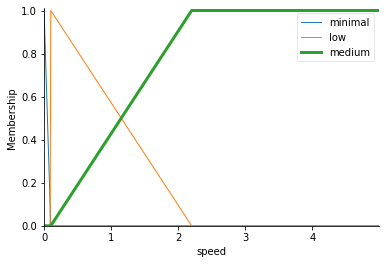

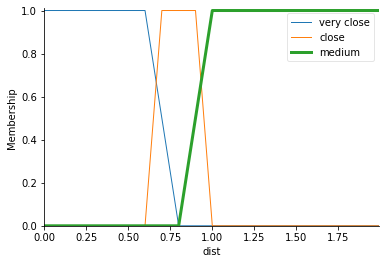

In [25]:
mod =  getPerpendicularStop()

In [26]:
mod.input["dist"] = 0.79

In [27]:
mod.compute()
print(mod.output['speed'])

0.7933913334119774


In [ ]:
vrep.simxFinish(-1) # closes all opened connections, in case any prevoius wasnt finished
clientID=vrep.simxStart('127.0.0.1',19999,True,True,5000,5) # start a connection

if clientID!=-1:
    print ("Connected to remote API server")
else:
    print("Not connected to remote API server")
    sys.exit("Could not connect")

#create instance of Tank
tank=Tank(clientID)

proximity_sensors=["EN","ES","NE","NW","SE","SW","WN","WS"]
proximity_sensors_handles=[0]*8

# get handle to proximity sensors
for i in range(len(proximity_sensors)):
    err_code,proximity_sensors_handles[i] = vrep.simxGetObjectHandle(clientID,"Proximity_sensor_"+proximity_sensors[i], vrep.simx_opmode_blocking)
    
#read and print values from proximity sensors
#first reading should be done with simx_opmode_streaming, further with simx_opmode_buffer parameter
for sensor_name, sensor_handle in zip(proximity_sensors,proximity_sensors_handles):
        err_code,detectionState,detectedPoint,detectedObjectHandle,detectedSurfaceNormalVector=vrep.simxReadProximitySensor(clientID,sensor_handle,vrep.simx_opmode_streaming)

tank.forward(5)
PP = getPerpendicular()
PS = getPerpendicularStop()
turn = False
forward = False
#continue reading and printing values from proximity sensors
t = time.time()
while (time.time()-t)<200: # read values for 5 seconds
    clear_output(wait=True)
    sensors={
        "EN":0,
        "ES":0,
        "NE":0,
        "NW":0,
        "SE":0,
        "SW":0,
        "WN":0,
        "WS":0,
    }
    for sensor_name, sensor_handle in zip(proximity_sensors,proximity_sensors_handles):
        err_code,detectionState,detectedPoint,detectedObjectHandle,detectedSurfaceNormalVector=vrep.simxReadProximitySensor(clientID,sensor_handle,vrep.simx_opmode_buffer )
        if(err_code == 0):
            print("Proximity_sensor_"+sensor_name, np.linalg.norm(detectedPoint))
            sensors[sensor_name] = (np.linalg.norm(detectedPoint))
    parkPerpendicular(sensors,tank,PP,PS)
    
    print(sensors)

average: 0.0
speed: 0.03333333333333334
{'EN': 0, 'ES': 0, 'NE': 0, 'NW': 0, 'SE': 0, 'SW': 0, 'WN': 0, 'WS': 0}
